In [2]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, ZeroPadding2D
import tensorflow.keras.layers as layers

import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, UpSampling2D, RepeatVector, Reshape
from tensorflow.keras.layers import concatenate
from keras.preprocessing.image import ImageDataGenerator
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from keras.models import load_model


from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from skimage.io import imread, imshow, imread_collection, concatenate_images

from keras import backend as K

seed = 42

In [3]:
data_dir = '/Users/ivanalchuk/.keras/datasets/flower_photos'

In [4]:
height = 160
width = 160
labels = ["roses", "sunflowers", "tulips", "dandelion", "daisy"]

In [5]:
%%time
pictures =[]

for l in labels:
    for path in os.listdir(os.path.join(data_dir, l)):
        full_path = os.path.join(data_dir, l, path)
        img = imread(full_path)
        img = resize(img, (height, width), mode='constant', preserve_range=True)                   
        pictures.append(img) 

CPU times: user 26.7 s, sys: 989 ms, total: 27.7 s
Wall time: 29 s


In [6]:
pictures = np.array(pictures)
pictures = pictures.astype('float32') / 255.

In [27]:
pictures = pictures[:2000]
train, test = train_test_split(pictures, test_size = 10, random_state = seed)

In [14]:
train_grey = gray2rgb(rgb2gray(train))

In [10]:
inception = InceptionResNetV2(weights='imagenet', include_top=True)

In [11]:
inception.graph = tf.compat.v1.get_default_graph()

In [8]:
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [11]:
def model_inception_with_u_net():

    inputs = layers.Input(shape= [height,width,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    d5 = down(512,(3,3),True)(d4)
    
    # Use InceptionResNetV2 as the fusion module
    inception_resnet = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(None, None, 3))
    inception_resnet.trainable = False  # Freeze the weights

    # Resize input to match InceptionResNetV2 input shape
    # Apply InceptionResNetV2 to the resized input
    inception_output = inception_resnet(inputs)
    
    inception_output = ZeroPadding2D(((2, 0), (2, 0)))(inception_output)
    
    # Concatenate the InceptionResNetV2 output with the last downsampled feature map
    fusion_output = layers.concatenate([d5, inception_output], axis=3)
    
    #upsampling
    u1 = up(512,(3,3),False)(fusion_output)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs , outputs=output)
    
    

In [12]:
model = model_inception_with_u_net()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 sequential_5 (Sequential)   (None, 80, 80, 128)          3584      ['input_3[0][0]']             
                                                                                                  
 sequential_6 (Sequential)   (None, 40, 40, 128)          147584    ['sequential_5[0][0]']        
                                                                                                  
 sequential_7 (Sequential)   (None, 20, 20, 256)          296192    ['sequential_6[0][0]']        
                                                                                              

In [28]:
model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

hist = model.fit(train_grey, train, epochs = 50,batch_size = 250,verbose = 1)

Epoch 1/50
1/1 [==============================] - 8s 8s/step - loss: 0.0722 - acc: 0.5955
Epoch 2/50
1/1 [==============================] - 5s 5s/step - loss: 0.1043 - acc: 0.4212
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.0923 - acc: 0.4850
Epoch 4/50
1/1 [==============================] - 4s 4s/step - loss: 0.0809 - acc: 0.5775
Epoch 5/50
1/1 [==============================] - 5s 5s/step - loss: 0.0841 - acc: 0.5813
Epoch 6/50
1/1 [==============================] - 5s 5s/step - loss: 0.0779 - acc: 0.5795
Epoch 7/50
1/1 [==============================] - 5s 5s/step - loss: 0.0762 - acc: 0.5634
Epoch 8/50
1/1 [==============================] - 5s 5s/step - loss: 0.0755 - acc: 0.5517
Epoch 9/50
1/1 [==============================] - 4s 4s/step - loss: 0.0730 - acc: 0.5525
Epoch 10/50
1/1 [==============================] - 5s 5s/step - loss: 0.0705 - acc: 0.5609
Epoch 11/50
1/1 [==============================] - 5s 5s/step - loss: 0.0682 - acc: 0.5727
Epoch 12

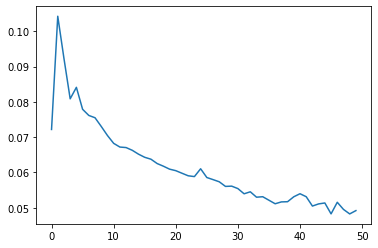

In [29]:
plt.plot(hist.history['loss'])

In [30]:
test_gray = gray2rgb(rgb2gray(test))

model.evaluate(test_gray,test)

1/1 [==============================] - 1s 1s/step - loss: 0.0837 - acc: 0.5359


[0.08370359987020493, 0.535882830619812]

1/1 [==============================] - 0s 71ms/step


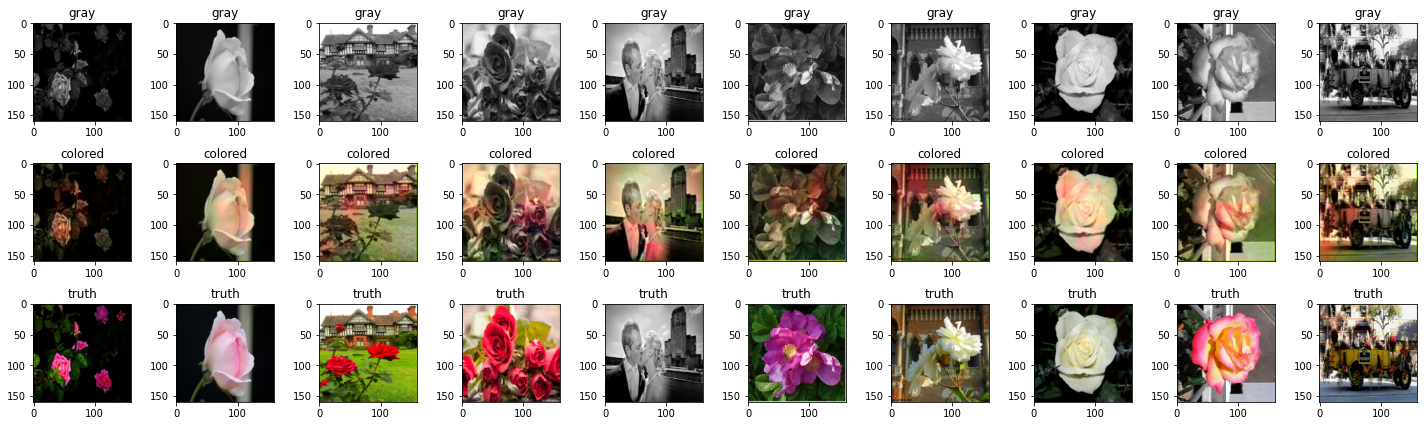

In [31]:
plt.figure(figsize=(20, 6))
for i, image in enumerate(test_gray):
    plt.subplot(3, 10, i + 1)
    colored  = np.clip(model.predict(image.reshape(1,160, 160,3)),0.0,1.0).reshape(160, 160,3)
    plt.imshow(image)
    plt.title('gray')
    
    plt.subplot(3, 10, i + 10 + 1)
    plt.imshow(colored)
    plt.title('colored')
    
    plt.subplot(3, 10, i + 20 + 1)
    plt.imshow(test[i])
    plt.title('truth')
    
plt.tight_layout()
    